In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from tqdm import tqdm_notebook
import cvxpy as cp
import pdb

# Utils

In [2]:
def best_arm_rnd(my_list):
    """
    returns the index i for which list[i] = max
    breaks ties at random
    """
    my_list = np.array(my_list)
    max_val = np.max(my_list)
    all_max = np.argwhere(my_list == max_val).flatten()
    return np.random.choice(all_max)


# Algorithms

## Algorithm class

In [3]:
class Algorithm:
    def __init__(self,
                nb_arms,
                horizon,
                noise_variance,
                ):
        """
        noise_variance: noise of reward
        """
        self.horizon = horizon
        self.nb_arms = nb_arms
        
        self.noise_variance = noise_variance
        self.noise_std = np.sqrt(noise_variance)
        

    
    def run_algo(self):
        raise NotImplementedError
        
    def run(self, NbExps, plot=True):
        """
        Run algo for NbExps experiments 
        """
        self.all_cumregrets = np.zeros((NbExps, self.horizon))
        for exp in (range(NbExps)):
            self.run_algo()
            cum_regret = np.cumsum(self.regret)
            self.all_cumregrets[exp,:] = cum_regret

        lower_regrets = np.percentile(self.all_cumregrets, 10, axis=0)
        upper_regrets = np.percentile(self.all_cumregrets, 90, axis=0)
        if plot:
            plt.fill_between(np.arange(self.horizon), lower_regrets,upper_regrets,alpha=0.2)
            plt.plot(np.mean(self.all_cumregrets,axis=0))
            plt.title(self.name)
            plt.xlabel('Iterations')
            plt.ylabel('Cumulative regret')
            plt.grid()
        return np.mean(self.all_cumregrets,axis=0), lower_regrets, upper_regrets

## GreedyBandit

In [217]:
class bastaniLinearContextualBandit(Algorithm):
    def __init__(self,
                 nb_arms,
                 d,
                 noise_variance=0.25,
                 horizon=10000,
                 beta_given=None,
                 context_param=(-1,1,0)):
        """
        - Contexts are drawn from Truncated gaussian + intercept, with parameters given by 
        context_param = (truncnorm lower, truncnorm upper, intercept) 
        - Rewards = mu_{At} + \cN(0,noise_std)
        """
        super().__init__(nb_arms=nb_arms, horizon=horizon, noise_variance=noise_variance)
        
        self.d = d # dimension of arms/of beta
        self.noise_variance = noise_variance
        self.noise_std = np.sqrt(noise_variance)
        
        self.context_param = context_param 
        self.name = f"BastaniLCB_K-{nb_arms}_d-{d}_T-{horizon}_std-{self.noise_std}"
        
  
        if beta_given is None:
            self.betas = np.random.normal(0,1,(self.nb_arms, 1, self.d,))#(K,1,d)
        else:
            self.betas = beta_given
    
    def reset_algo(self):
        self.regret = np.zeros((self.horizon,)) # Regret history
        
        # self.l_S[i]: list of instants where arm i is drawn
        self.l_S = [[] for i in range(self.nb_arms)]
        
        
        self.context = np.zeros((self.horizon, self.d, 1)) # Contexts history
        self.reward = np.zeros((self.horizon,1)) # Rewards history
        
        
        self.beta_hat = np.zeros((self.nb_arms, 1, self.d)) # Current beta_hat
        assert self.beta_hat.shape == self.betas.shape, str(self.betas.shape) + str(self.beta_hat.shape)
            
        self.Sigma_cov = np.zeros((self.nb_arms, self.d, self.d)) # Hat sigma Covariance matrix
        
        
        
                               
        # analysis computations
        self.nb_times_drawn = np.zeros((self.nb_arms,),dtype=np.int16) 
        self.diff_beta = np.zeros((self.nb_arms, self.horizon)) # l1norm(beta-beta_hat)
        self.eig_min_cov = np.zeros((self.nb_arms, self.horizon)) # minimum eigenvalue of cov_i
    
        
    def sample_context(self):
        """
        Sample from truncated normal + intercept 
        Default: there is covariate diversity, intercept = 0
        return: 
         - context of size (d,1)
        """
        l, u, intercept = self.context_param 
        context = truncnorm.rvs(l, u, size=(self.d,1)) + intercept
        return context
                            
    
    def choose_arm(self,context):
        """
        Greedy bandit

        """
        mu_hat = np.dot(self.beta_hat, context).flatten()
        return best_arm_rnd(mu_hat)
   
                               
    def update_beta_hat(self, arm):
        """
        Update self.beta_hat when arm is drawn
        """
        S_arm = self.l_S[arm] # instants up to t when arm was drawn
        arm_contexts = self.context[S_arm] # contexts when arm was drawn (len(S_arm), d, 1)
        cov = self.Sigma_cov[arm,:,:] # covariance of contexts when instants in S_arm (d,d)
        if np.linalg.det(cov) != 0:
            self.beta_hat[arm] = np.linalg.inv(cov).dot(arm_contexts.T[0]).dot(self.reward[S_arm]).T
            
        
    def update_stats(self, t, idx_arm):
        """
        Update contexts, l_rewards, l_S at t,
        when context is drawn and arm is chosen 
        """
        true_mus = np.dot(self.betas, self.context[t]).flatten()
        self.reward[t] = true_mus[idx_arm] + np.random.normal(0, self.noise_std)
        self.regret[t] = np.max(true_mus) - true_mus[idx_arm]
                        
        self.l_S[idx_arm].append(t)  
        
        self.Sigma_cov[idx_arm,:,:] += self.context[t].dot(self.context[t].T)
        self.update_beta_hat(idx_arm)
        
        #not mandatory quantities:                     
        self.nb_times_drawn[idx_arm] += 1
        self.diff_beta[:,t] = np.abs(self.betas - self.beta_hat).sum(axis=2).sum(axis=1)
        for k in range(self.nb_arms):
            if k == idx_arm:
                self.eig_min_cov[k,t] = np.min(np.linalg.eigvals(self.Sigma_cov[k,:,:]))
            elif t>0:
                self.eig_min_cov[k,t] = self.eig_min_cov[k,t-1]
        
    
    def plot_eigmin(self):
        for k in range(self.nb_arms):
            plt.plot(self.eig_min_cov[k][:], label="arm " +str(k))
        plt.ylabel("Minimum eigenvalue of \hat\Sigma(S_kt)")
        plt.xlabel("Iterations")
        plt.grid()
        plt.legend()
        
        
        
    def run_algo(self):
        self.reset_algo()
        for t in (range(self.horizon)):
            self.context[t] = self.sample_context()
            idx_arm_t = self.choose_arm(context=self.context[t])
                               
            self.update_stats(t=t, idx_arm=idx_arm_t)
            
            

In [218]:
class HaoBastaniSettingOne(bastaniLinearContextualBandit):
    """
    Hao cast into Bastani setting (cf setting (1))
    """
    def __init__(self,
                 nb_arms,
                 theta,
                 noise_variance=0.25,
                 horizon=10000,
                 context_param=(-1,1,0)):
        """
        d_hao is the dimension of Hao problem
        d = nb_arms*d_hao
        """
        
        self.theta = theta
        self.d_hao = self.theta.shape[0]
        betas = np.zeros((nb_arms,1,nb_arms*d))
        for k in range(nb_arms):
            betas[k][0][k*d:(k+1)*d] = self.theta.flatten()
        
        super().__init__(nb_arms,
                 d=nb_arms*self.d_hao,
                 noise_variance=noise_variance,
                 horizon=horizon,
                 beta_given=betas,
                 context_param=context_param)
        
        n = self.horizon
        delta = 1/self.horizon
        self.fn = (2*(1+1/np.log(n))*np.log(1/delta)\
                   + self.d*np.log(self.d*np.log(n)))
        
    def reset_algo(self):
        super().reset_algo()
        self.cov_G = np.zeros((self.d_hao, self.d_hao))
        self.sum_XY = np.zeros((self.d_hao,1))
        
        self.inv_cov_G = None
        self.norm_x_G_inv = [[] for k in range(self.nb_arms)] # ||x||_{G_t^-1}^2
        self.Delta_hat = []
        self.Delta_hat_min = 1e4
        
    
    def compute_cov_G(self):
        cov_G = np.zeros((self.d_hao, self.d_hao))
        for i in range(self.nb_arms):
            cov_G += self.Sigma_cov[i][i*self.d_hao:(i+1)*self.d_hao,i*self.d_hao:(i+1)*self.d_hao]
        return cov_G
    
    def update_stats(self, t, idx_arm):
        super().update_stats(t=t,idx_arm=idx_arm)
        arm = self.context[t][idx_arm*self.d_hao:(idx_arm+1)*self.d_hao] #arm hao (d_hao,1)
        action_set = self.context[t].reshape(self.nb_arms, self.d_hao)
        self.cov_G += arm.dot(arm.T)
        
        self.sum_XY += self.reward[t]*arm #useful to compute theta_hat, 
        
        if self.inv_cov_G is None:
            if np.linalg.matrix_rank(self.cov_G) == self.d_hao:
                self.inv_cov_G = np.linalg.inv(self.cov_G)
        else: 
            w = self.inv_cov_G.dot(arm)
            self.inv_cov_G = self.inv_cov_G - (w.dot(w.T))/(1+float(arm.T.dot(w))) #Sherman Morrison
            for k in range(self.nb_arms):
                # compute norm_x_G_inv
                arm_k = self.context[t][k*self.d_hao:(k+1)*self.d_hao]
                self.norm_x_G_inv[k].append(float(arm_k.T.dot(self.inv_cov_G).dot(arm_k)))
                
            # compute theta_hat and Delta_hat
            self.theta_hat = self.inv_cov_G.dot(self.sum_XY)
            hao_mu_hat = action_set.dot(self.theta_hat).flatten() #(K,1)
            mu_opt_hat = np.max(hao_mu_hat)

            self.Delta_hat.append(mu_opt_hat - hao_mu_hat)
            self.Delta_hat_min = min(self.Delta_hat_min,
                                     np.min(self.Delta_hat[-1][self.Delta_hat[-1]>0])) # compute min over all c_t?
                
    def run_algo(self):
        super().run_algo()
        

In [193]:
class HaoBastaniSettingTwo(bastaniLinearContextualBandit):
    """
    Setting (2)
    """
    def __init__(self,
                 nb_arms,
                 d,
                 noise_variance=0.25,
                 horizon=10000,
                 context_param=(-1,1,0)):
        """
        d_hao is the dimension of Hao problem
        d_hao = K*d
        """
        
        super().__init__(nb_arms,
                 d=d,
                 noise_variance=noise_variance,
                 horizon=horizon,
                 beta_given=None,
                 context_param=context_param)
        self.theta = self.betas.reshape(self.nb_arms*self.d,1)
        self.d_hao = self.theta.shape[0]
        
        n = self.horizon
        delta = 1/self.horizon
        self.fn = (2*(1+1/np.log(n))*np.log(1/delta)\
                   + self.d*np.log(self.d*np.log(n)))
        
    def reset_algo(self):
        super().reset_algo()
        self.cov_G = np.zeros((self.d_hao, self.d_hao))
        self.sum_XY = np.zeros((self.d_hao,1))
        
        self.inv_cov_G = None
        self.norm_x_G_inv = [[] for k in range(self.nb_arms)] # ||x||_{G_t^-1}^2
        self.Delta_hat = []
        self.Delta_hat_min = 1e4
        
    
    def compute_cov_G(self):
        cov_G = np.zeros((self.d_hao, self.d_hao))
        for i in range(self.nb_arms):
            cov_G[i*self.d:(i+1)*self.d,i*self.d:(i+1)*self.d] = self.Sigma_cov[i]
        return cov_G
    
    def update_stats(self, t, idx_arm):
        super().update_stats(t=t,idx_arm=idx_arm)
        arm = np.zeros((self.d_hao, 1))
        arm[idx_arm*self.d:(idx_arm+1)*self.d] = self.context[t]
        action_set = np.zeros((self.nb_arms, self.d_hao))
        for k in range(self.nb_arms):
            action_set[k][k*self.d:(k+1)*self.d] = self.context[t].flatten()
        
        
        self.cov_G += arm.dot(arm.T)
        
        self.sum_XY += self.reward[t]*arm #useful to compute theta_hat, 
        
        if self.inv_cov_G is None:
            if np.linalg.matrix_rank(self.cov_G) == self.d_hao:
                self.inv_cov_G = np.linalg.inv(self.cov_G)
        else: 
            w = self.inv_cov_G.dot(arm)
            self.inv_cov_G = self.inv_cov_G - (w.dot(w.T))/(1+float(arm.T.dot(w))) #Sherman Morrison
            all_norm = np.diag(action_set.dot(self.inv_cov_G).dot(action_set.T))
            for k in range(self.nb_arms):
                # compute norm_x_G_inv
                self.norm_x_G_inv[k].append(all_norm[k])
                
            # compute theta_hat and Delta_hat
            self.theta_hat = self.inv_cov_G.dot(self.sum_XY)
            hao_mu_hat = action_set.dot(self.theta_hat).flatten() #(K,1)
            mu_opt_hat = np.max(hao_mu_hat)

            self.Delta_hat.append(mu_opt_hat - hao_mu_hat)
            self.Delta_hat_min = min(self.Delta_hat_min,
                                     np.min(self.Delta_hat[-1][self.Delta_hat[-1]>0])) # compute min over all c_t?
                
    def run_algo(self):
        super().run_algo()
        #print(self.cov_G)
        #print(self.compute_cov_G())
        

## Optimal allocation matching

In [159]:
class haoLinearContextualBandit(Algorithm):
    def __init__(self,
                 action_sets,
                 noise_variance=1,
                 horizon=10000,
                 theta_given=None,
                 action_set_proba=None
                 ):
        
        self.action_sets = action_sets # (M,K,d)
        self.M = self.action_sets.shape[0]
        
        super().__init__(nb_arms=self.action_sets.shape[1],
                         horizon=horizon, 
                         noise_variance=noise_variance,
                         )
        self.d = self.action_sets.shape[2]
        self.theta_given = theta_given #(d,1)             
        self.name = f"Hao_K-{self.nb_arms}_d-{self.d}_T-{horizon}_std-{self.noise_std}"
        self.crit_opt = 1.1 # whenever det(G_t) increases by crit_opt, recompute opt (Not implemented)
        self.action_set_proba = action_set_proba #if specified, list of probabilities for each context
        
        #self.fn = self.f_n_d(n=self.horizon,delta=1/self.horizon)
        
        # To change?
        self.lam = 0.01
        
    def init_theta(self):
        """
        Initialize theta and true mus
        """
        if self.theta_given is None:
            self.theta = np.random.normal(0,1,(self.nb_arms, 1, self.d,))
        else:
            self.theta = self.theta_given
            assert self.theta_given.shape == self.theta_hat.shape
        self.true_mus = self.action_sets.dot(self.theta).reshape(self.M, self.nb_arms) 
        self.true_mu_opt = np.max(self.true_mus, axis=1).reshape(self.M,1)
        self.true_delta = self.true_mu_opt - self.true_mus
    
    def f_n_d(self,
              n=None,
              delta=None,
              t=None
              ):
        """
        Compute f_{n,\delta} 
        """
        c = 1
        if n is None:
            n = self.horizon
        if delta is None:
            delta = 1/self.horizon
            
        if n ==1: 
            n+= 1
            
        fnd = (2*(1+1/np.log(n))*np.log(1/delta)\
               + c*self.d*np.log(self.d*np.log(n)))
        
        if t is not None:                
            dd = 1/(1+t)
            ft_2 = (2*np.log(self.det_G[-1]**0.5*(np.linalg.det(self.lam*np.identity(self.d))**-0.5)/dd))**0.5\
             + self.lam**0.5*np.linalg.norm(self.theta)#: uses theta
            ft_1 = 2*(1+1/np.log(t))*np.log(t*np.log(t)) + self.d*np.log(self.d*np.log(t))
        else:
            ft_2 = None
            ft_1 = None
        
        

        return fnd, ft_1, ft_2
   
    def reset_algo(self):
        self.explo_count = 0
        self.nb_times_drawn = np.zeros((self.M, self.nb_arms), dtype=np.int16)
        
        self.regret = np.zeros((self.horizon,)) # Regret history
        self.reward = np.zeros((self.horizon,)) # Rewards history
        
        self.mu_hat = np.zeros((self.nb_arms,))
        self.Delta_hat = np.zeros((self.M, self.nb_arms))
        self.theta_hat = np.zeros((self.d, 1))
        self.init_theta()
        
        self.sum_XY = np.zeros((self.d,1))
        
        # To change?
        self.cov_G = self.lam*np.eye(self.d)# np.zeros((self.d, self.d))
        self.inv_cov_G = np.linalg.inv(self.cov_G)
        # Others
        self.max_repeat_T = 0 # Incremented when optimization returns None (should not be too high)         
        self.diff_theta = np.zeros((self.horizon,))
        self.wasted_explo = 0
        self.force_explo = 0
        self.det_G = []
        self.diff_delta = np.zeros((self.horizon,))
        
    def sample_action_set(self,):
        """
        sample according to self.action_set_proba 
        Return:
        action context A_ct : (K,d)
        context = idx of context (\in self.M)
        """
        assert len(self.action_set_proba) == self.M
        assert sum(self.action_set_proba) == 1
        
        rnd = np.random.uniform(low=0, high=1)
        probabilities = [0] + self.action_set_proba
        cur_sum = 0
        for m in range(self.M):
            if cur_sum  <= rnd <= cur_sum + probabilities[m+1]:
                context = m
                break
            cur_sum = cur_sum + probabilities[m+1]
   
        return self.action_sets[context], context

    def compute_optimization(self, f_opt=None, ft=None):
        """
        Solve the approximated allocation rule
        min \sum_m \sum_x T_x^m \hat{delta}_x^m
        st 
        T_x^m >= 0
        x^T {H_T^-1}^2 x <= (\hat{delta}_x^m^2 / f_n) for all x
        H_T = \sum_m \sum_x T_x^m  xx^T
        """
        
            
        deltas = self.Delta_hat.flatten() # (M*K,)
        T = cp.Variable(self.M * self.nb_arms) # (M*K,)
        H_T = cp.Variable((self.d, self.d))
        
        
        all_arms = self.action_sets.reshape(self.M*self.nb_arms,
                                            self.d)
        
        # Changes
        if f_opt is None:
            f_opt = self.fn
        if ft is None:
            ft = 2
        dfn = np.square(deltas)/f_opt
        #idx_non_zeros = np.where(dfn > 0)[0]
        idx_zeros = np.where(dfn == 0)[0]
        dfn[idx_zeros] += 0.001
        max_T = 1e4
        
        objective = cp.Minimize(T @ deltas)
        eps = 0
        constraints = [T >= eps] + \
                      [T <= max_T] + \
                      [H_T == all_arms.T @ cp.diag(T) @ all_arms ] + \
                      [cp.matrix_frac(all_arms[k], H_T) <= dfn[k] for k in range(self.nb_arms)]
                       #idx_non_zeros] 
                      
        problem = cp.Problem(objective, constraints)
        opt_val = problem.solve()
        
        
        T = T.value
        H_T = H_T.value
        
        if T is not None:
            T[T<0.01] = 0
            T = T*ft/2
            self.T = T.reshape(self.M, self.nb_arms)
        else: self.max_repeat_T += 1
        return H_T
        
    def choose_LinUCB(self, A_ct, context):
        """
        LinUCB policy
        """
        self.wasted_explo += 1
        bonus = np.sqrt(self.f_ucb)*self.norm_x_G_inv(A_ct=A_ct)**0.5
        #bonus = np.sqrt(self.f_n_d(delta=1/self.explo_count**2))*self.norm_x_G_inv(A_ct=A_ct)**0.5
        return best_arm_rnd(self.mu_hat[context] + bonus)
    
    def compute_b1_b2(self, context):
        """
        Returns indices of arm b1, b2 when doing exploration
        """
        tmp_b1 = (self.nb_times_drawn[context]\
                  /np.min([self.T[context],
                           self.fn/self.Delta_hat_min**2*np.ones(self.nb_arms)], axis=0))
        b1 = np.argmin(tmp_b1)
        b2 = np.argmin(self.nb_times_drawn[context])
        return b1, b2
         
    def explore(self, A_ct, context):
        """
        Returns index of arm chosen when doing exploration
        """
        self.explo_count += 1
        
        cond = np.min([self.T[context],
                      (self.fn/self.Delta_hat_min**2)*np.ones((self.nb_arms,))], axis=0)
        
        if (self.nb_times_drawn[context] >= cond).all():
            return self.choose_LinUCB(A_ct=A_ct, context=context)
        else:
            b1, b2 = self.compute_b1_b2(context=context)
            if self.nb_times_drawn[context][b2] <= 0*self.explo_param*(self.explo_count-1):
                #print("b2", b2)
                self.force_explo += 1
                return b2
            else:
                #print("b1", b1)
                return b1
         
    def norm_x_G_inv(self,  A_ct, idx_arm=None):
        """
        Compute ||x||_{G^-1}^2 if the index of a single arm is specified (returns float)
        Otherwise returns a (K,) array where each entry k is ||x_k||_{G^-1}^2
        A_ct: (K,d)
        """
        inv_cov_G = self.inv_cov_G
        if A_ct is None and arm is not None:
            arm = A_ct[idx_arm].reshape(self.d,1)
            return float(arm.dot(inv_cov_G).dot(arm.T))
        elif A_ct is not None:
            return np.diag(A_ct.dot(inv_cov_G).dot(A_ct.T))
        else:
            raise ValueError
    
    def should_exploit(self, A_ct, context):
        """
        Return true if for all x in A_ct,
        ||x||_{G_{t-1}^-1}^2 <= max(delta_min/fn, delta_x/fn)
        """
        x_G_inv = self.norm_x_G_inv(A_ct=A_ct) #(K,)
       
        assert x_G_inv.shape[0] == self.nb_arms
        cond = np.max([(self.Delta_hat_min**2/self.fn) * np.ones((self.nb_arms,)),
                       np.square(self.Delta_hat[context])/self.fn], axis=0)

        if (x_G_inv <= cond).all():
            return True
        else:
            #print(x_G_inv)
            #print(f"cond = {cond} \n")
            return False
            
    def update_stats(self, t, A_ct, context, idx_arm, init_phase=False):
        self.nb_times_drawn[context, idx_arm] += 1
        arm = A_ct[idx_arm].reshape(self.d,1)
        
        
        true_mus_ct = self.true_mus[context]# A_ct.dot(self.theta)
        
        reward_noise = np.random.normal(0,self.noise_std)
        self.reward[t] = true_mus_ct[idx_arm] + reward_noise
        self.regret[t] = np.max(true_mus_ct) - true_mus_ct[idx_arm]        
        self.cov_G = self.cov_G + arm.dot(arm.T)
        self.inv_cov_G = np.linalg.inv(self.cov_G)
        self.sum_XY = self.sum_XY + self.reward[t]*arm
        
        # Not necessary for algorithm:
        self.diff_theta[t] = np.linalg.norm((self.theta-self.theta_hat))
        self.det_G.append(np.linalg.det(self.cov_G))
        
        
        
        if t >= self.d-1:
            assert np.linalg.matrix_rank(self.cov_G) == self.d, np.linalg.matrix_rank(self.cov_G)
            self.theta_hat = self.inv_cov_G.dot(self.sum_XY)
            self.mu_hat = self.action_sets.dot(self.theta_hat).reshape(self.M, self.nb_arms) 
            mu_opt_hat = np.max(self.mu_hat, axis=1).reshape(self.M,1)
            self.Delta_hat = mu_opt_hat - self.mu_hat
            self.Delta_hat_min = np.min(self.Delta_hat[self.Delta_hat>0])
            
            # Not necessary for algorithm:
            self.diff_delta[t] = np.linalg.norm(self.Delta_hat-self.true_delta)
            
            # To change?
            #self.explo_param = 1/np.log(np.log(t+1))
            self.explo_param = 1/np.log(t+1)**0.5
            
            self.fn, ft_1, ft_2 = self.f_n_d(t=t+1)
            #self.fn = self.f_n_d(delta=1/(t+1))#n=t, delta=1/t)
            #self.f_ucb = self.f_n_d()#n=t,delta=1/(self.explo_count+1)**2)
            #self.f_ucb,_,_ = self.f_n_d(delta=1/(self.explo_count+1)**2)
            self.ft = min(ft_1,ft_2)
            self.fn = self.ft
            self.f_ucb = self.ft
                      
    def init_phase(self,):
        """
        Perform initialization phase (draw arms not in the span of previously drawn arms)
        """
        past_arms = np.zeros((self.d,self.d))
        for t in range(self.d):
            A_ct, context = self.sample_action_set()
            potentials = []
            for k in range(self.nb_arms):
                past_arms[t] = A_ct[k]
                if np.linalg.matrix_rank(past_arms) == t+1:
                    potentials.append(k)
           
            assert len(potentials) >= 1, past_arms
            idx_arm = np.random.choice(potentials)
            past_arms[t] = A_ct[idx_arm]
            self.update_stats(t=t,
                              A_ct=A_ct, 
                              context=context, 
                              idx_arm=idx_arm,
                             init_phase=True)
        
    def run_algo(self):
        self.reset_algo()
        self.init_phase()

        for t in range(self.d, self.horizon):
            if t %(self.horizon//4)==0:
                print(f"*********  t = {t}, Nb of times solver failed: {self.max_repeat_T}")
            A_ct, context = self.sample_action_set()
            self.compute_optimization(f_opt=2, ft=self.ft)
            #print(self.T)
            #print(self.ft)
            if self.should_exploit(A_ct=A_ct, context=context):
                idx_arm = best_arm_rnd(self.mu_hat[context])
            else:
                idx_arm = self.explore(A_ct=A_ct, context=context)
                
            self.update_stats(t=t, A_ct=A_ct, context=context, idx_arm=idx_arm)
            #print("V", self.cov_G)
            #print("reward", self.reward[t])
            #print(self.Delta_hat)
            #print(self.Delta_hat_min)
            #print("regret",self.regret[t])
        print(f"Nb explorations: {self.explo_count}")
        print(f"Nb wasted explo: {self.wasted_explo}")
        print(f"Nb force explo: {self.force_explo}")
        print(f"N : {self.nb_times_drawn}")



# Experiments

## From Hao to Bastani setting

Recall Hao setting: 
- Context: $c_t \sim p$, distribution over [M] (discrete)
- Choose $x_k^{c_t}, $ among $A^{c_t} = (x_1^{c_t},\dots ,x_K^{c_t}) $
- Receive reward $ y = x_k^T \theta$
- In this setting, we define $G_t = \sum_{s=1}^t x_s x_s^T$

Recall Bastani setting:
- Context : $X_t \sim p$
- Choose $\beta_k, k\in [K]$ 
- Receive reward $ y = \beta_k^T X_t$
- In this setting, we define $\hat{\Sigma}(S_{i,t}) = \sum_{s \in S_{i,t}} X_s X_s^T$ where the $S_{i,t}$ are the instants where arm $i$ is chosen.



(1) From Hao to Bastani:
- Let $\theta \in \mathbb{R}^d$.
- Set $\beta_k = (0_d, \dots, \theta, \dots, 0_d)$ for $k \in [K]$. $\beta_k \in \mathbb{R}^{Kd}$
- Let $X_t$ be the random variable $\in \mathbb{R}^{Kd}$, $||X_t||<1$ corresponding to the context in the Bastani setting. We cannot rigorously cast one setting to the other, because of the assumption that M is discrete. But let us sample $X_t$ from a continuous distribution, as if $M = T$, the horizon (i.e. we never get the same context again). 
We can write $X_t = (x_1^m, x_2^m, \dots, x_K^m)$ where the $x_j^m \in \mathbb{R}^d$. At each time $c_t = m = t \in [M] = [T]$.
- Choosing arm $\beta_k$ in the Bastani setting boils down to choosing $x_k^m$ among the contextual action set $\{x_1^m, x_2^m, \dots, x_K^m \}$. The reward received when choosing arm $k$ is then $y_t = \beta_k^T X_t = \theta^T x_k^{c_t}$.
- To compute $G_t$ from  the $\hat{\Sigma}(S_{i,t})$, we sum over the i, each square block of $\hat{\Sigma}(S_{i,t})$ which indices are given by `[i*d:(i+1)*d, i*d:(i+1)*d]`. Formally, if we denote $J_i$ the matrix which contains only zeros except for the block `[i*d:(i+1)*d, i*d:(i+1)*d]`, where it contains the identity $I_d$, and $H$ a $(Kd \times d)$ matrix which contains the concatenation of $K$ identity matrices $I_d$,  we have $G_t = H^T(\sum_{i=1}^K J_i \hat{\Sigma}(S_{i,t}) J_i)H$.


(2) From Bastani to Hao:
- Let $\beta_1, \beta_2, \dots \beta_K \in \mathbb{R}^d$.
- Set $\theta = (\beta_1, \beta_2, \dots \beta_K)$
- Let $X_t$ be the random variable $\in \mathbb{R}^{d}$, $||X_t||<1$ corresponding to the context in the Bastani setting. We define the contextual action set of Hao setting as $A^{c_t} = \{ (X_t, 0_d, \dots, 0_d), (0_d, X_t,  \dots, 0_d), (0_d, \dots, 0_d, X_t) \}$.
- The reward received when choosing arm $k$ is then $y_t = \beta_k^T X_t = \theta^T x_k^m$.
- Then, $G_t = \sum_{s=1}^t x_s x_s^T$ is block diagonal. The diagonal block of index `[i*d:(i+1)*d, i*d:(i+1)*d]` corresponds to $\hat{\Sigma}(S_{i,t})$.

Should we exploit or not ?

- In Bastani, we keep being greedy if for all $i \in [K]$, $\lambda_\min(\hat{\Sigma}(S_{i,t}))$ keeps growing linearly with t: for each arm i, the contexts leading to choosing arm i are diverse.  <br>
- In Hao, we exploit when $||x_i^{c_t}||_{G_t^{-1}} \leq \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$ for all $i \in A^{c_t}$. This means that the directions of all arms of $A^{c_t}$ have been well explored.
- It seems that the condition of Bastani implies that of Hao in formulation (2). Indeed, 

\begin{align*}
&\lambda_\min(\hat{\Sigma}(S_{i,t})) \geq Ct \\
&\Rightarrow  \lambda_\max(\hat{\Sigma}(S_{i,t})^{-1}) \leq \frac{1}{Ct}  \text{, when $\hat{\Sigma}(S_{i,t})^{-1}$ is invertible} \\
&\Rightarrow \forall x, x^T \hat{\Sigma}(S_{i,t})^{-1} x \leq \frac{C'}{t}, \text{ when $||x||_2$ is bounded (which is the case for our arms)}
\end{align*}


-> In (2), we have $||x_i^{c_t}||_{G_t^{-1}} = x_i^{c_t T} G_t^{-1} x_i^{c_t} = X_t^{T} \hat{\Sigma}(S_{i,t})^{-1} X_t \leq \frac{C'}{t} $. Intuitively as t grows, the $\hat{\Delta}$ are better estimated  and $f_n$ is a constant so we will get $||x_i^{c_t}||_{G_t^{-1}} \leq \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$.
Let us check this implication:

## Setting (2):

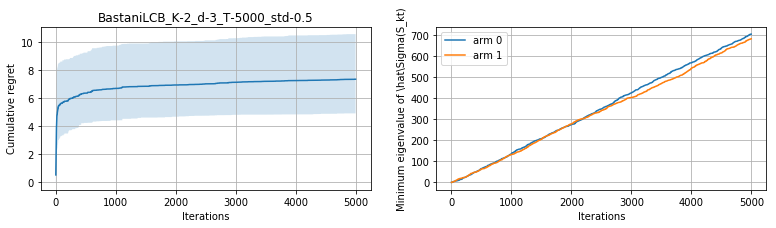

In [199]:
# Example with covariate diversity: contexts are drawn from truncated Gaussian
# The betas are generated randomly 
# Theta is set as specified above (2)
K = 2
d = 3
T = 5000
test = HaoBastaniSettingTwo(nb_arms=K,
                 d=d,
                 noise_variance=0.25,
                 horizon=T,
                 context_param=(-1,1,0))
plt.figure(figsize=(13,3))
plt.subplot(121)
regret = test.run(NbExps=5)
plt.subplot(122)
# Sanity check: the eigenvalues indeed grow linearly
test.plot_eigmin()

Let us plot diff = $ \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right] - x^T G_t^{-1} x$ with respect to iterations, for each arm i. (Left figure below)

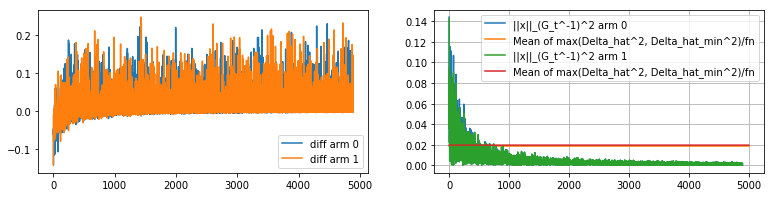

In [203]:
start_t = 100
plt.figure(figsize=(13,3))
for k in range(K):
    delta_hat_fn = [max(test.Delta_hat_min**2,test.Delta_hat[t][k]**2)/test.fn for t in range(start_t,len(test.Delta_hat))]
    mean_k = np.array(delta_hat_fn).mean()
    
    plt.subplot(121)
    #plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    #plt.plot(delta_hat_fn, label=f"arm {k}")
    plt.plot(np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:]),label=f"diff arm {k}")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    plt.plot(mean_k*np.ones(T), label="Mean of max(Delta_hat^2, Delta_hat_min^2)/fn")
    #plt.plot((np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:])).mean()*np.ones(T),
     #        label=f"mean diff arm {k}")
    plt.legend()
plt.grid()


We see that diff is often positive. On the left, we see that the mean of  $ \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$ over iterations is quickly above $ x^T G_t^{-1} x$: this means that the Optimal allocation matching algorithm would be exploiting. Here, there is covariate diversity and we indeed "often" have $x^T G_t^{-1} x \leq \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$.

This suggests that the implication Covariate diversity => Hao condition may seem correct.

Now, let us try without covariate diversity, i.e. an intercept added to the sampled context.

/home/cindy/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:105: ComplexWarning: Casting complex values to real discards the imaginary part


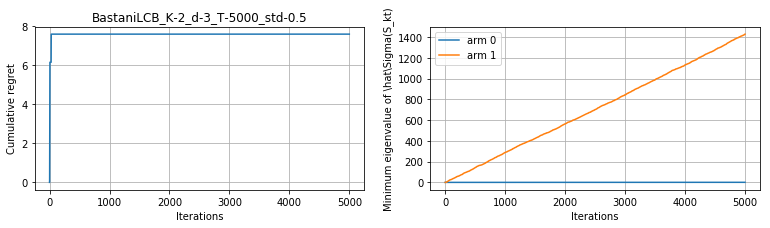

In [214]:
# Example without covariate diversity: contexts are drawn from truncated Gaussian + intercept
K = 2
d = 3
T = 5000
intercept = 3
test = HaoBastaniSettingTwo(nb_arms=K,
                 d=d,
                 noise_variance=0.25,
                 horizon=T,
                 context_param=(-1,1,intercept))
plt.figure(figsize=(13,3))
plt.subplot(121)
regret = test.run(NbExps=1)
plt.subplot(122)
test.plot_eigmin()

Let us plot diff = $ \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right] - x^T G_t^{-1} x$ with respect to iterations, for each arm i. (Left figure below)

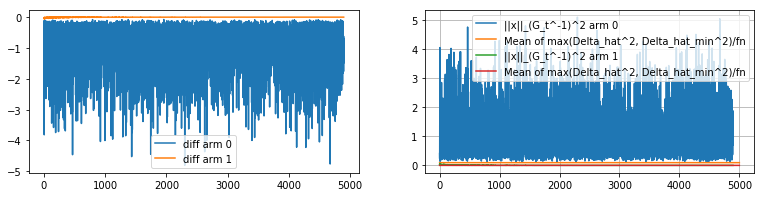

In [215]:
start_t = 100
plt.figure(figsize=(13,3))
for k in range(K):
    delta_hat_fn = [max(test.Delta_hat_min**2,test.Delta_hat[t][k]**2)/test.fn for t in range(start_t,len(test.Delta_hat))]
    mean_k = np.array(delta_hat_fn).mean()
    
    plt.subplot(121)
    #plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    #plt.plot(delta_hat_fn, label=f"arm {k}")
    plt.plot(np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:]),label=f"diff arm {k}")
    plt.legend()
    #plt.grid()
    
    plt.subplot(122)
    plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    plt.plot(mean_k*np.ones(T), label="Mean of max(Delta_hat^2, Delta_hat_min^2)/fn")
    #plt.plot((np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:])).mean()*np.ones(T),
     #        label=f"mean diff arm {k}")
    plt.legend()
plt.grid()


Now, without covariate diversity, we see that it is the contrary: the Hao  condition  $x^T G_t^{-1} x \leq \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$ does not hold anymore and so the Optimal Algorithm Matching would not continue to exploit.

## Setting (1): Casting Hao to Bastani setting

- In (1) such a link (covariate diversity => Hao condition) is more complicated to establish ($x^T G_t^{-1} x = x^T (H^T\sum_{i=1}^K J_i \hat{\Sigma}(S_{i,t}) J_i H)^{-1} x$). We can however simulate an environment where covariate diversity holds, and see if the condition $x^T G_t^{-1} x \leq \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$ is verified. 

/home/cindy/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:105: ComplexWarning: Casting complex values to real discards the imaginary part


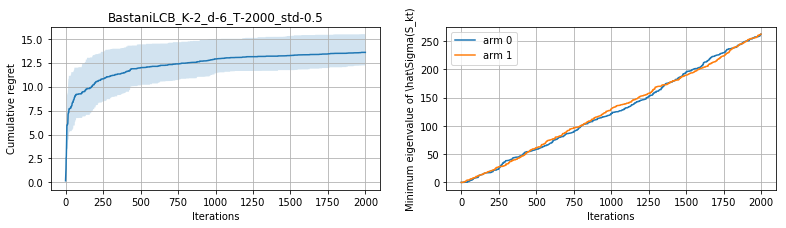

In [151]:
# Example with covariate diversity: contexts are drawn from truncated Gaussian
K = 2
d = 3
T = 2000
theta = np.array([[1],
                  [0.5],
                  [1]])

test = HaoBastaniSettingOne(nb_arms=K,
                 theta=theta,
                 noise_variance=0.25,
                 horizon=T,
                 context_param=(-1,1,0))
plt.figure(figsize=(13,3))
plt.subplot(121)
regret = test.run(NbExps=5)
plt.subplot(122)
# Sanity check: the eigenvalues indeed grow linearly
test.plot_eigmin()

Let us plot diff = $ \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right] - x^T G_t^{-1} x$ with respect to iterations, for each arm i. (Left figure)

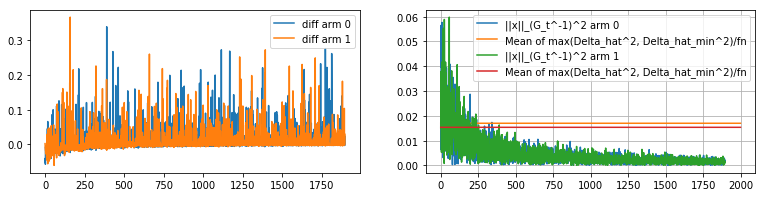

In [172]:
start_t = 100
plt.figure(figsize=(13,3))
for k in range(K):
    delta_hat_fn = [max(test.Delta_hat_min**2,test.Delta_hat[t][k]**2)/test.fn for t in range(start_t,len(test.Delta_hat))]
    mean_k = np.array(delta_hat_fn).mean()
    
    plt.subplot(121)
    #plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    #plt.plot(delta_hat_fn, label=f"arm {k}")
    plt.plot(np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:]),label=f"diff arm {k}")
    plt.legend()
    #plt.grid()
    
    plt.subplot(122)
    plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    plt.plot(mean_k*np.ones(T), label="Mean of max(Delta_hat^2, Delta_hat_min^2)/fn")
    #plt.plot((np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:])).mean()*np.ones(T),
     #        label=f"mean diff arm {k}")
    plt.legend()
plt.grid()


We see that diff is often positive. On the left, we see that the mean of  $ \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$ over iterations is quickly under $ x^T G_t^{-1} x$: this means that the Optimal allocation matching algorithm would be exploiting. Here, there is covariate diversity and we indeed "often" have $x^T G_t^{-1} x \leq \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$.

Let us see a case without covariate diversity.

/home/cindy/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:105: ComplexWarning: Casting complex values to real discards the imaginary part


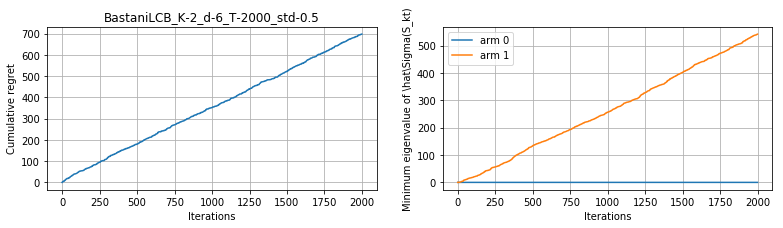

In [219]:
# Example without covariate diversity: contexts are drawn from truncated Gaussian + intercept
K = 2
d = 3
T = 2000
intercept = 10
theta = np.array([[1],
                  [0.3],
                  [-0.5]])

test = HaoBastaniSettingOne(nb_arms=K,
                 theta=theta,
                 noise_variance=0.25,
                 horizon=T,
                 context_param=(-1,1,intercept))

plt.figure(figsize=(13,3))
plt.subplot(121)
regret = test.run(NbExps=1)
plt.subplot(122)
# One arm has a \hat\Sigma(S_kt) with smallest eigenvalue which is not growing
test.plot_eigmin()

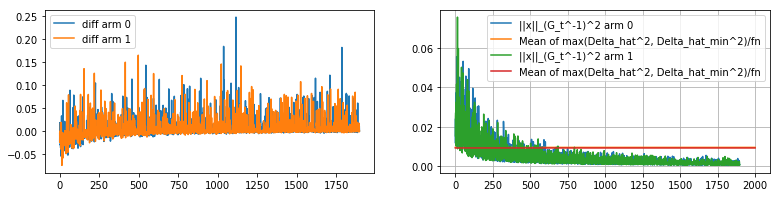

In [220]:
start_t = 100
plt.figure(figsize=(13,3))
for k in range(K):
    delta_hat_fn = [max(test.Delta_hat_min**2,test.Delta_hat[t][k]**2)/test.fn for t in range(start_t,len(test.Delta_hat))]
    mean_k = np.array(delta_hat_fn).mean()
    
    plt.subplot(121)
    #plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    #plt.plot(delta_hat_fn, label=f"arm {k}")
    plt.plot(np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:]),label=f"diff arm {k}")
    plt.legend()
    #plt.grid()
    
    plt.subplot(122)
    plt.plot(test.norm_x_G_inv[k][start_t:], label=f'||x||_(G_t^-1)^2 arm {k}')
    plt.plot(mean_k*np.ones(T), label="Mean of max(Delta_hat^2, Delta_hat_min^2)/fn")
    #plt.plot((np.array(delta_hat_fn) - np.array(test.norm_x_G_inv[k][start_t:])).mean()*np.ones(T),
     #        label=f"mean diff arm {k}")
    plt.legend()
plt.grid()


Like in the case with covariate diversity, most of the time, diff is often positive. Again on the left, we see that the mean of  $ \max \left[\frac{\hat{\Delta}_i^{c_t}}{f_n}, \frac{\hat{\Delta}_\min}{f_n} \right]$ over iterations is quickly under $ x^T G_t^{-1} x$.
Unlike in setting (2), there is no covariate diversity here, but the Optimal Allocation Matching algorithm would still be exploiting. 
In fact, this is not surprising because in Setting (1), the dimension of $\theta$ is smaller than that of $\beta$, and so even though all the directions of $\mathbb{R^{Kd}}$ are not well explored (meaning that we cannot really well estimating the $\beta$s), the directions of $\mathbb{R^d}$ are well explored, allowing us to estimate $\theta$ well:

In [226]:
# Well estimated, cov_G has large eigenvalues
print(f'Theta: {test.theta.flatten()}') 
print(f'Theta_hat: {test.theta_hat.flatten()}') 
print(np.linalg.eigvals(test.cov_G))

Theta: [ 1.   0.3 -0.5]
Theta_hat: [ 0.98644732  0.31320534 -0.50070881]
[5.99750856e+05 5.77919629e+02 5.48813288e+02]


In [225]:
#Not well estimated:
print(f'betas: {test.betas.flatten()}') 
print(f'beta_hat: {test.beta_hat.flatten()}') 
print(np.linalg.eigvals(test.cov_G))

betas: [ 1.   0.3 -0.5  0.   0.   0.   0.   0.   0.   1.   0.3 -0.5]
beta_hat: [-2.14495209 -0.63381674 -0.72250099  1.84896311 -0.33215529  1.02205683
 -0.01573609 -0.01068855  0.00222999  0.99442129  0.32167471 -0.49299761]


This means that we do not have the implication Hao condition => Covariate diversity.